In [1]:
%load_ext autoreload
%autoreload 2

%pylab inline
import numpy as np
import pandas as pd

import seaborn as sns
sns.set_style('ticks')
sns.set_context('paper')
import os

import eternabench as eb

Populating the interactive namespace from numpy and matplotlib


In [27]:
zscores = pd.read_csv(os.environ['ETERNABENCH_PATH']+'/scoring_data/EternaBench_external_zscores_by_dataset_MANUAL_COMPILED.csv')

package_order=['rnastructure','vienna_2','vienna_2_60C','rnastructure_60C', 'rnasoft_blstar', 'contrafold_2','eternafold_B']
package_data = eb.plot.get_packages()

title_order = [packages.loc[x]['title'] for x in package_order]
types = ['viral_gRNA','SARS-CoV-2_gRNA','mRNA','rRNA','synthetic RNA']

In [19]:
title_order

['RNAstructure',
 'Vienna 2',
 'Vienna 2, 60˚C',
 'RNAstructure, 60˚C',
 'RNAsoft BLstar',
 'CONTRAfold 2',
 "Model SCRR ('EternaFold')"]

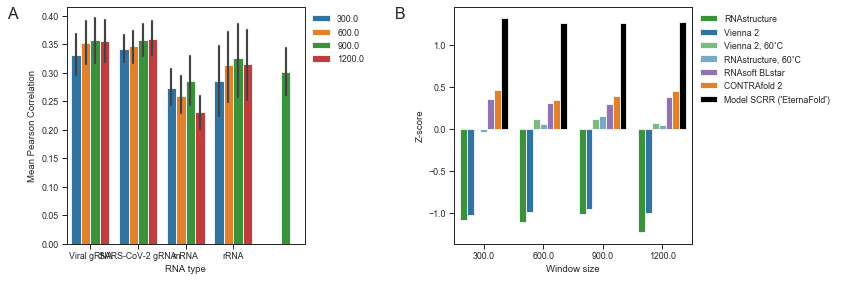

In [28]:
figure(figsize=(12,4))
subplot(1,2,1)
sns.barplot(x='Class',y='pearson_mean', data=zscores, hue='window_size')
legend(frameon=False, bbox_to_anchor=(1,1))
ylabel('Mean Pearson Correlation')
xlabel('RNA type')
xticks(range(4), ['Viral gRNA','SARS-CoV-2 gRNA','mRNA','rRNA'])
eb.plot.label_subplot('A')

blue, orange, green, red, purple, brown, _, _, _, _=sns.color_palette()
light_Green = sns.color_palette('Greens',3)[1]
light_blue = sns.color_palette('Blues',3)[1]
palette = [brown, blue, red, green, orange, purple, [0,0,0]]

subplot(1,2,2)

palette=[green, blue, light_Green, light_blue, purple, orange, [0,0,0]]
sns.barplot(x='window_size',y='pearson_zscore_by_Dataset_mean', data=zscores.merge(package_data,on='package'),hue='title',hue_order=title_order, palette=palette,ci=False)
legend(bbox_to_anchor=(1,1),frameon=False)
eb.plot.label_subplot('B')
ylabel('Z-score')
xlabel('Window size')

tight_layout()

# savefig('FIGURES/SI/all_windows_analysis.pdf',bbox_inches='tight')
# savefig('FIGURES/SI/all_windows_analysis.png',dpi=300, bbox_inches='tight')

70
42
63
21
64


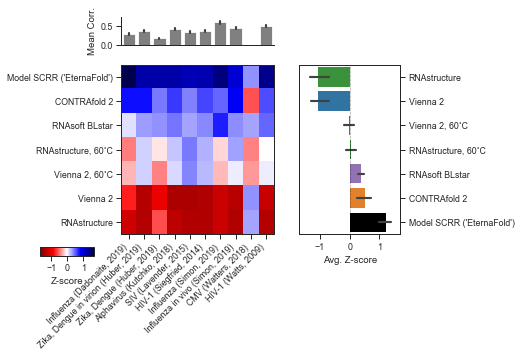

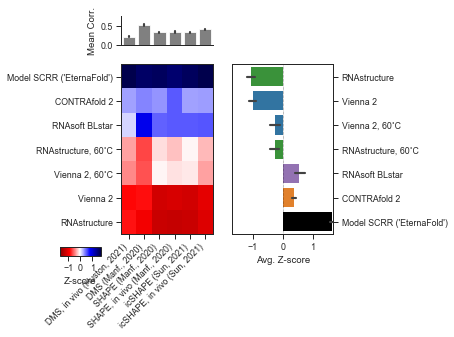

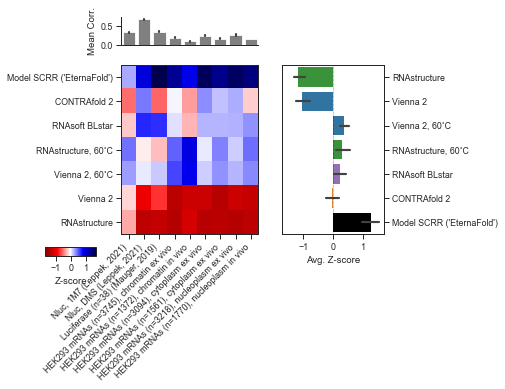

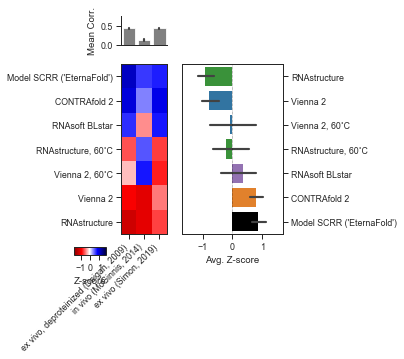

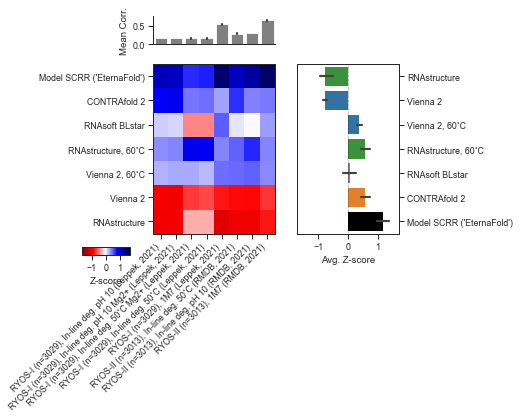

In [31]:
for i, rna in enumerate(types):
    tmp_zscores = zscores.loc[zscores.window_size==900][zscores.Class==rna]
    print(len(tmp_zscores))
    n=len(tmp_zscores.Dataset.unique())
    
    eb.plot.ranked_heatmap_w_bar_overhead(tmp_zscores, package_order=package_order, vmin=-1.7,vmax=1.7,
                                          figsize=(.3*n+2,4), width_ratios=[.3*n, 2], ext=True)
    #savefig('FIGURES/4/%s_heatmap.pdf' % rna,bbox_inches='tight')

<Figure size 432x288 with 0 Axes>

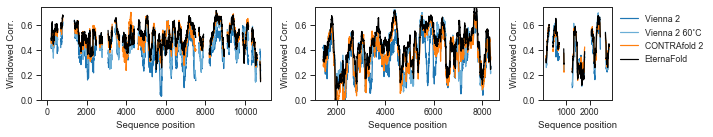

In [33]:
ex_data=['Huber (2019), ZILM','Sun, 2019 HEK293 chromatin in vitro ENST00000534336',
         'Deigan, 2009 ex vivo deproteinized e. Coli 23S rRNA' ]

blue, orange, green, red, purple, brown, _, _, _, _=sns.color_palette()
palette = [brown, blue, red, green,orange, purple, [0,0,0]]

titles=['Vienna 2', 'Vienna 2 60˚C', 'CONTRAfold 2','EternaFold']

packages = ['vienna_2', 'vienna_2_60C','contrafold_2', 'eternafold_B']

light_blue=sns.color_palette('Blues',3)[1]

colors=[blue, light_blue, orange,'k']

figure(figsize=(6,4))

gridkw = dict(width_ratios=[10,8,3])
fig, ax = plt.subplots(1,3, gridspec_kw=gridkw, figsize=(10,2))

letters=list('CDE')

for ex_ind, ex in enumerate(ex_data):
    for p, pkg in enumerate(packages):
        df = pd.read_json(os.environ['ETERNABENCH_PATH']+'/data/ExternalDatasetsCalculations/CM_%s.json.zip' % pkg)
        tmp = df.loc[df.name==ex]
        n=tmp['orig_seqpos'].iloc[-1][-1]+1
        cat_r = {k:[] for k in range(n)}
        cat_p = {k:[] for k in range(n)}
        for _, row in tmp.iterrows():
            for i, orig in enumerate(row['orig_seqpos']):
                cat_p[orig].append(row['p_%s' % pkg][i])
                cat_r[orig].append(row['reactivity'][i])

        cat_R = [cat_r[i][0] for i in range(n)]
        cat_P = [np.nanmedian(cat_p[i]) for i in range(n)]

        dat = pd.DataFrame({'R': cat_R, 'P': cat_P})
        ax[ex_ind].plot(dat['R'].rolling(150).corr(dat['P']),c=colors[p],label=titles[p])
    ax[ex_ind].set_ylabel('Windowed Corr.')
    ax[ex_ind].set_ylim([0,0.75])

    ax[ex_ind].set_xlabel('Sequence position')
    if ex_ind==2:
        legend(bbox_to_anchor=(1,1),frameon=False)
    
tight_layout()

# Global folding assessment

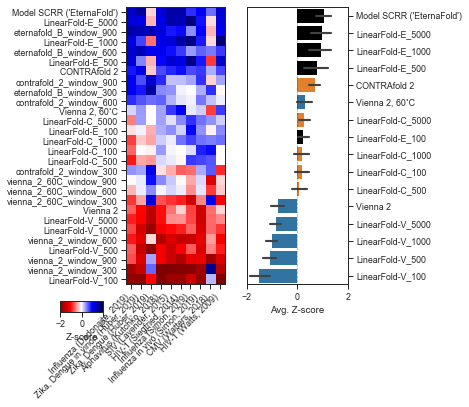

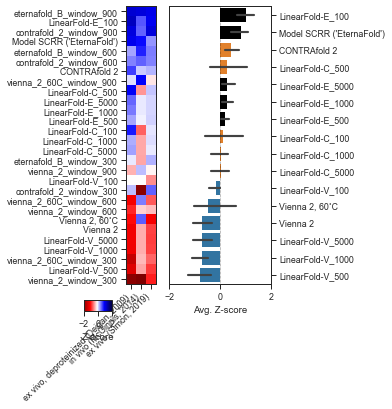

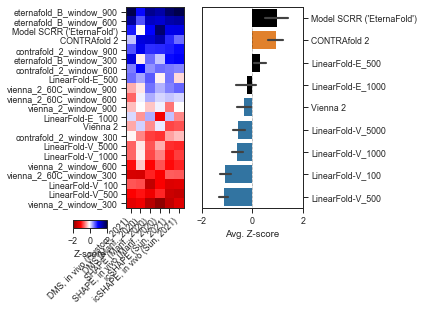

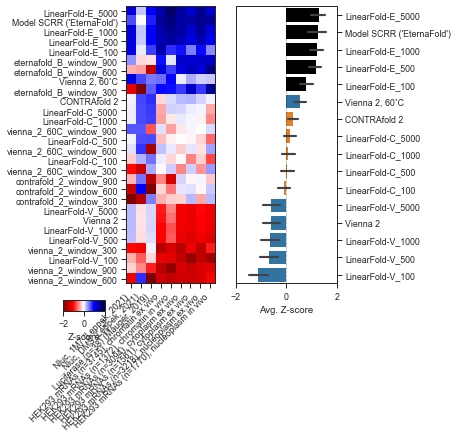

In [40]:
df = pd.read_json(os.environ['ETERNABENCH_PATH']+'/data/ExternalData/thermodynamic_global_folding_data.json.zip')
tmp1 = df.loc[~df.package.str.contains('LinearFold')]

tmp2 = df.loc[df.package.str.contains('LinearFold')]
tmp2 = tmp2.loc[~tmp2.package.str.contains('window')]

df = tmp1.append(tmp2, ignore_index=True)


types=['viral_gRNA', 'rRNA', 'SARS-CoV-2_gRNA', 'mRNA',]

for i, rna in enumerate(types):

    if rna=='SARS-CoV-2_gRNA':
        zscores, _ = eb.stats.calculate_Z_scores(df.loc[df.Class==rna][~df.package.isin(['LinearFold-E_100','LinearFold-E_5000','vienna_2_60C'])])
        
    else:
        zscores, _ = eb.stats.calculate_Z_scores(df.loc[df.Class==rna])
        
    n=len(zscores.Dataset.unique())
    k = len(zscores.package.unique())
    
    eb.plot.ranked_heatmap(zscores, vmin=-2,vmax=2,figsize=(.2*n+2,.2*k-0.5),width_ratios=[.2*n, 2],ext=True)
    #savefig('FIGURES/SI/global_thermo_ranking_%s.pdf' % rna, bbox_inches='tight')
    

# Perform significance test

In [37]:
ctr=0

zscores_window_900 = zscores.loc[zscores.window_size==900]

for ds in zscores_window_900.Dataset.unique():
    tmp = zscores_window_900.loc[zscores_window_900.Dataset==ds]
    not_efold = tmp.loc[tmp.package!='eternafold_B']
    efold_min_cutoff = tmp.loc[tmp.package=='eternafold_B']['pearson_percentile_2.5'].values[0]
    if all(efold_min_cutoff > not_efold['pearson_percentile_97.5'].values):
        print('YES', ds)
        ctr+=1
    else:
        print('NO', ds)
        
        for pkg in ['contrafold_2', 'rnasoft_blstar','vienna_2_60C','rnastructure_60C','vienna_2','rnastructure']:
            pkg_max_cutoff = tmp.loc[tmp.package==pkg]['pearson_percentile_97.5'].values[0]
            if efold_min_cutoff < pkg_max_cutoff:
                print('\t%s tied, %.2f, %.2f' % (pkg, efold_min_cutoff, pkg_max_cutoff))
            not_pkg = tmp.loc[tmp.package!=pkg]
            pkg_min_cutoff = tmp.loc[tmp.package==pkg]['pearson_percentile_2.5'].values[0]   
            if all(pkg_min_cutoff > not_pkg['pearson_percentile_97.5'].values):
                print('BUT: %s won' % pkg)

print('FINAL COUNT', ctr)

YES Dadonaite,2019
YES Huber, 2019 in virion
NO Huber, 2019 in vitro
	contrafold_2 tied, 0.18, 0.20
	rnasoft_blstar tied, 0.18, 0.20
	vienna_2_60C tied, 0.18, 0.19
	rnastructure_60C tied, 0.18, 0.19
	vienna_2 tied, 0.18, 0.18
	rnastructure tied, 0.18, 0.18
YES Kutchko,2018
YES Lavender,2015
YES Siegfried,2014
YES Simon,2019 Invitro
NO Simon,2019 Invivo
	contrafold_2 tied, 0.48, 0.51
	rnasoft_blstar tied, 0.48, 0.49
	rnastructure_60C tied, 0.48, 0.49
NO Watters,2018
	contrafold_2 tied, -0.04, 0.04
	rnasoft_blstar tied, -0.04, 0.07
	vienna_2_60C tied, -0.04, 0.05
	rnastructure_60C tied, -0.04, 0.05
	vienna_2 tied, -0.04, 0.08
	rnastructure tied, -0.04, 0.08
YES Watts,2009
YES Huston, 2021 SARS-CoV-2 in vivo
NO Manfredonia, 2020 SARS-CoV-2 DMS in vitro
	rnasoft_blstar tied, 0.56, 0.56
YES Manfredonia, 2020 SARS-CoV-2 SHAPE in vitro
YES Manfredonia, 2020 SARS-CoV-2 SHAPE in vivo
YES Sun, 2021 SARS-CoV-2 in vitro
YES Sun, 2021 SARS-CoV-2 in vivo
NO Leppek, 2021, Nluc mRNA 1M7 in vitro
	cont

In [35]:
len(zscores)

861